Mounted at /content/gdrive
Length of All Notes in The Midis : 59618 

Length of All Unique Notes in The Corpus: 197 

Some Samples of Notes in The Corpus (first 10 samples from 59618): 

['C#5', 'A3', 'E4', 'D5', 'B3', 'C#5', '4.9', 'E5', '1.4', 'E5'] 

Average Frequencies of Each Notes in The Corpus: 302.6294416243655 

+-------------------------------------+--------+-------------+
|                                     |  Note  |  Frequency  |
+-------------------------------------+--------+-------------+
|   Most Frequent Note in The Corpus  |   D5   |     3116    |
|  Least Frequent Note in The Corpus  | 10.1.4 |      1      |
+-------------------------------------+--------+-------------+ 



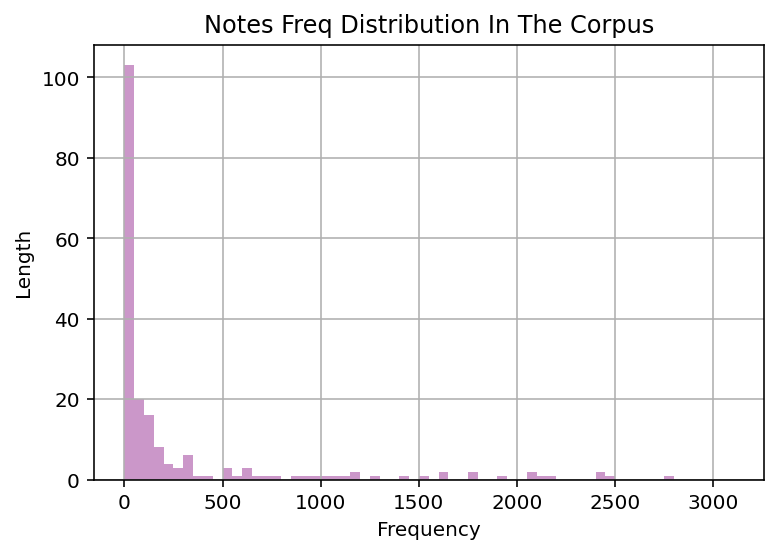

Number of Rare Notes: 123 

Length of Corpus after Rare Notes Elemination: 57248 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 40, 512)           1052672   
                                                                 
 dropout (Dropout)           (None, 40, 512)           0         
                                                                 
 lstm_1 (LSTM)               (None, 256)               787456    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                       

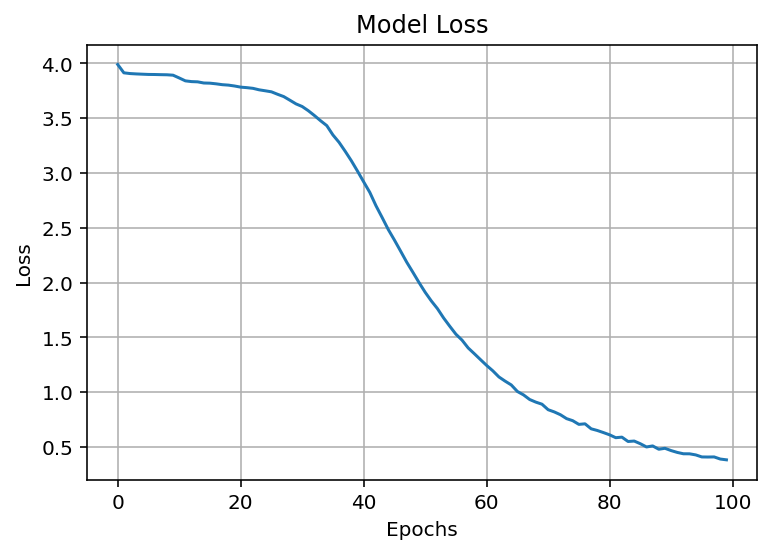

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import tensorflow 
import matplotlib.patches as mpatches
import numpy as np 
import pandas as pd 
import random
import IPython
import matplotlib.pyplot as plt 
import music21
import tensorflow.keras.backend as K
from IPython.display import Image, Audio
import collections
from music21 import *
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adamax
from os import listdir
from google.colab import drive
from prettytable import PrettyTable
drive.mount('/content/gdrive')
%matplotlib inline
np.random.seed(42)

class MusicGeneration:
  def __init__(self, length):
    self.dropoutFlag = False
    self.corpus = None
    self.midis = []
    self.dictionary = {"Notes":list(),"Frequency":list()}
    self.rareNote = []
    self.model = Sequential()
    self.length = length
    
  def loadMusic(self,path):
    for file in listdir(path):
        if file.endswith(".mid"):
            self.midis.append(converter.parse(path+file))
  
  def extract_notes(self):
      notes = []
      pick = None
      for j in self.midis:
          songs = instrument.partitionByInstrument(j)
          for part in songs.parts:
              pick = part.recurse()
              for element in pick:
                  if isinstance(element, note.Note):
                      notes.append(str(element.pitch))
                  elif isinstance(element, chord.Chord):
                      notes.append(".".join(str(n) for n in element.normalOrder))
      return notes

  def getCorpus(self):
    self.corpus = self.extract_notes()
    print("Length of All Notes in The Midis :", len(self.corpus),'\n')
    print("Length of All Unique Notes in The Corpus:", len(collections.Counter(self.corpus)),'\n')
    print("Some Samples of Notes in The Corpus (first 10 samples from "+ str(len(self.corpus)) +"):",'\n')
    print(self.corpus[:10],'\n')

  def createDictionaty(self):
    self.dictionary['Notes'] = list(collections.Counter(self.corpus).keys())
    self.dictionary['Frequency'] = list(collections.Counter(self.corpus).values())
    print("Average Frequencies of Each Notes in The Corpus:", sum(self.dictionary['Frequency'])/len(self.dictionary['Frequency']),'\n')
    table = PrettyTable()
    column_names = [" ", " Note ", " Frequency "]
    table.add_column(column_names[0], [" Most Frequent Note in The Corpus ", " Least Frequent Note in The Corpus "])
    table.add_column(column_names[1], [self.dictionary['Notes'][self.dictionary['Frequency'].index(max(self.dictionary['Frequency']))], self.dictionary['Notes'][self.dictionary['Frequency'].index(min(self.dictionary['Frequency']))]])  
    table.add_column(column_names[2], [max(self.dictionary['Frequency']), min(self.dictionary['Frequency'])])  
    print(table,'\n')
    
    plt.figure(1)
    bins = np.arange(0,(max(self.dictionary['Frequency'])), 50) 
    plt.hist(self.dictionary['Frequency'], bins=bins, color="#cb97c9")
    plt.grid()
    plt.title("Notes Freq Distribution In The Corpus")
    plt.ylabel("Length")
    plt.xlabel("Frequency")
    plt.show()

  def rareNotesElemination(self):
    for key, value in collections.Counter(self.corpus).items():
        if value < 100:
            self.rareNote.append(key)
    for element in self.corpus:
      if element in self.rareNote:
          self.corpus.remove(element)
    print("Number of Rare Notes:", len(self.rareNote),'\n')
    print("Length of Corpus after Rare Notes Elemination:", len(self.corpus),'\n')


  def musicGenerator(self, N):
    test_ = self.xTest[np.random.randint(0,len(self.xTest)-1)]
    notesGenerated=[]
    music = ""
    for i in range(N):
        test_ = test_.reshape(1,self.length,1)
        pred = self.model.predict(test_, verbose=0)[0]
        pred = np.log(pred) / 1.0
        pred_ = np.exp(pred)
        pred = pred_ / np.sum(pred_)
        index_N = np.argmax(pred)/ float(len(self.symb))   
        notesGenerated.append(np.argmax(pred))
        music = [self.rvsMapping[char] for char in notesGenerated]
        test_ = np.insert(test_[0],len(test_[0]),index_N)
        test_ = test_[1:]
    return music, stream.Stream(self.chords_n_notes(music))  

  def chords_n_notes(self, Snippet):
    Melody = []
    offset = 0
    for i in Snippet:
        if ("." in i or i.isdigit()):
            chord_notes = i.split(".")
            notes = [] 
            for j in chord_notes:
                inst_note=int(j)
                note_snip = note.Note(inst_note)            
                notes.append(note_snip)
                chord_snip = chord.Chord(notes)
                chord_snip.offset = offset
                Melody.append(chord_snip)
        else: 
            note_snip = note.Note(i)
            note_snip.offset = offset
            Melody.append(note_snip)
        offset += 1
    Melody_midi = stream.Stream(Melody)   
    return Melody_midi

  def train(self, dropoutFlag = False):
    self.dropoutFlag = dropoutFlag
    self.train_()

  def train_(self):
    self.symb = sorted(list(set(self.corpus)))
    mapping = dict((c, i) for i, c in enumerate(self.symb))
    self.rvsMapping = dict((i, c) for i, c in enumerate(self.symb))
    desired = []
    features = []
    for i in range(0, len(self.corpus) - self.length, 1):
        feature = self.corpus[i:i + self.length]
        target = self.corpus[i + self.length]
        features.append([mapping[j] for j in feature])
        desired.append(mapping[target])
    X = (np.reshape(features, (len(desired), self.length, 1)))/ float(len(self.symb))
    y = tensorflow.keras.utils.to_categorical(desired) 
    self.xTrain, self.xTest, self.yTrain, self.yTest = train_test_split(X, y, test_size=0.2, random_state=42)
    self.model.add(LSTM(512, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
    if self.dropoutFlag:
      self.model.add(Dropout(0.15))
    self.model.add(LSTM(256))
    if self.dropoutFlag:
      self.model.add(Dropout(0.15))
    self.model.add(Dense(256))
    if self.dropoutFlag:
      self.model.add(Dropout(0.15))
    self.model.add(Dense(y.shape[1], activation='softmax'))
    opt = Adamax(learning_rate=0.01)
    self.model.compile(loss='categorical_crossentropy', optimizer=opt)
    self.model.summary()
    self.result = self.model.fit(self.xTrain, self.yTrain, batch_size=256, epochs=100)

  def plotLoss(self):    
    plt.figure(2)
    plt.plot(pd.DataFrame(self.result.history)["loss"])
    plt.title("Model Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.grid()
    plt.show()

  def generateMusic(self):
    Music_notes, generateed_music = self.musicGenerator(100)
    generateed_music.write('midi','gdrive/MyDrive/Colab Notebooks/mini project 2/generated music.mid')

if __name__ == '__main__':
  model = MusicGeneration(length = 40)
  # model.loadMusic("gdrive/MyDrive/Colab Notebooks/mini project 2/Classical Music MIDI/chopin/") 
  model.loadMusic("gdrive/MyDrive/Colab Notebooks/mini project 2/Classical Music MIDI/mozart/") 
  model.getCorpus()
  model.createDictionaty()
  model.rareNotesElemination()
  model.train(dropoutFlag = True)
  model.plotLoss()
  model.generateMusic()
